<div style="background-color: #28a745 !important; color: white; min-height: 50px; padding: 10px; margin: auto;">
    <p style="text-align: right; font-style: italic">STMKGxHMGI Long Course</p>
    <h1>Sesi: Penentuan Hiposenter Pendekatan Analitik: Metode Geiger</h1>
</div>
<div style="background-color: whitesmoke; padding: 10px ">
    <ul>
        <li>Tujuan: Memperkenalkan sekilas dasar dan implementasi perhitungan hiposenter dengan Metode Geiger pada keadaan bawah permukaan homogen</li>
        <li>Keluaran: Peserta dapat memahami sekilas dasar kemudian mengimplementasikan dalam Python</li>
        <li>Sesi Mater</li>
        <li>Waktu/Tempat: Sabtu, 25 September 2021/ Zoom</li>
    </ul>
</div>

## Penentuan Hiposenter Pendekatan Analitik: Metode Geiger
### Sekilas Dasar
Pada penentuan hiposenter dengan Metode Geiger kita akan menghitung secara iteratif dengan memasukkan sebuah tebakan awal parameter model yang dicari ($X,Z,T$). Proses iteratif ini dilakukan didasari dari konsep linearisasi yang diterapkan pada fenomena perambatan gelombang yang tidak linear. Waktu tempuh perambatan gelombang badan (misal P) ($t_i$) pada kasus 2D ($X,Z$) dengan bawah permukaan yang homogen  dapat dinyatakan sebagai:

$$t_i=f_i(X,Z,T)=T+\frac{\sqrt{(X-x_j)^2-(Z-z_j)^2}}{v},$$

dengan $T$ merupakan *origin time*, $X$ dan $Z$ merupakan koordinat sumber, $x_j$ dan $z_j$ merupakan koordinat stasiun perekam, dan $v$ merupakan kecepatan, persamaan di atas adalah persamaan majunya. Dalam fenomenanya $t_i$ merupakan data yang kita punya hasil dari *picking* waktu tiba sehingga akan kita tulis sebagai $\mathbf{d}=\{t_1,t_2,t_3,...,t_N\}$ untuk 1 sampai $N$. Parameter model yang akan kita cari adalah letak hiposenter dan waktu kejadian (*origin time*) yang selanjutnya dapat kita tuliskan sebagai $\mathbf{m}=\{X,Z,T\}$. Karena hubungan data dan model non linear maka dapat kita nyatakan dengan:

$$\mathbf{d}=f(\mathbf{m}),$$

Dengan memanfaatkankan deret Taylor sampai suku kedua kita dapat melinearisasi hubungan di atas menjadi:

$$ m = m_0 + \Delta m,$$

dengan $m_0$ merupakan tebakan awal dan $\Delta m$ merupakan koreksi dari model kita. Sesuai relasi pada deret Taylor, nilai $\Delta m$ dapat kita jabarkan secara linear dengan error data ($\Delta d$) memanfaatkan turunan parsial terhadap model yang dikemas dalam Jacobian ($G$):

$$\Delta d = G\Delta m$$

sehingga dengan Least Square solusinya merupakan:

$$\Delta m = (G^TG)^{-1}G^Td.$$

Nilai $\Delta m$ ini yang akan dicari setiap iterasi untuk mengoreksi nilai tebakan $m_0$ yang akan terus diupdate sepanjang iterasi.

### Implementasi
#### Membuat model sintetik

Kita akan membuat data sintetik yang nantinya akan kita cari hiposenternya menggunakan metode Geiger, data sintetik dapat dicari dengan persamaan maju (persamaan pertama). Mula-mula kita harus menuliskan dulu letak hiposenter, *origin time*, dan kecepatan bawah permukaan dalam Python:

In [105]:
import numpy as np

# Koordinat stasiun                      # (original values)
station_x = np.array([ 5,10,15,25])      # x(km) = [ 5,10,15,25]
station_z = np.array([ 0, 0, 0, 0])      # z(km) = [ 0, 0, 0, 0]

# Hiposenter, origin time, dan kecepatan gelombang P
source_x = 16                            # hiposenter x (km) = 16
source_z = 15                            # hiposenter z (km)= 15
origin_T = 17                            # origin time (s) = 17
v_exact  =  5                            # kecepatan gel P (km/s) = 5

kemudian membuat fungsi untuk menghitung waktu tempuh sesuai dengan persamaan maju, fungsi ini akan kita pakai juga saat inversi nanti:

In [106]:
# membuat fungsi untuk menghitung jarak (phytagoras)
def distance(x1,z1,x2,z2):
    xterm = (x2-x1)**2
    zterm = (z2-z1)**2
    comb = (xterm+zterm)**(1/2)
    return comb

# persamaan maju
def t_arr_calc(xs,zs,x,z,t0):
    t_arr = t0 + (distance(xs,zs,x,z)/v_exact)
    return t_arr

selanjutnya adalah menghitung waktu tiba sintetik untuk masing-masing stasiun:

In [108]:
# Menghitung data waktu tiba sintetik
t_obs = np.zeros(np.size(station_x))
for i in range(0,np.size(station_x)):  # loop terhadap stasiun
    t_obs[i] = t_arr_calc(station_x[i],station_z[i],source_x,source_z,origin_T)
print(t_obs)

[20.72021505 20.23109888 20.00665928 20.49857114]


#### Membuat tebakan

Tebakan ($X,Z,T$) akan kita tulis dalam bentuk *array*:

In [109]:
guess=np.array([15,16,16])
print(guess)

[15 16 16]


#### Menghitung error  data

Tebakan kita tentunya belum merupakan solusinya, tebakan ini akan kita hitung seberapa cocok atau tidak cocok dengan data asli. Caranya adalah melakukan pemodelan maju dengan lokasi hiposenter tebakan kita:

In [111]:
# persamaan maju
d_calc = t_arr_calc(station_x,station_z,guess[0],guess[1],\
                    guess[2])

d_calc

array([19.77359245, 19.35261092, 19.2       , 19.77359245])

dari data kalkulasi yang kita dapatkan $d_{calc}$ kita hitung nilai errornya dengan mengurangkan secara sederhana:

In [112]:
# mengganti variabel t_obs menjadi data (d)
d=t_obs

# menghitung delta_d
delta_d = d - d_calc

delta_d

array([0.94662259, 0.87848796, 0.80665928, 0.72497868])

di atas merupakan perbedaan data observasi dan data_kalkulasi yang dapat kita simbolkan dengan $\Delta d$, dengan nilai ini kita dapat melakukan inversi untuk mendapatkan koreksi model tetapi sebelumnya kita harus membuat algoritma untuk mencari matriks $G$.

#### Membuat matriks Jacobian

Matriks Jacobian terdiri dari turunan parsial persamaan maju ($t_i$) terhadap masing-masing model ($X,Z,T$):

\begin{bmatrix}
 \frac{\partial t_1}{\partial x}   & \frac{\partial t_1}{\partial z}  & \frac{\partial t_1}{\partial T} \\ 
\frac{\partial t_2}{\partial x}   & \frac{\partial t_2}{\partial z}  & \frac{\partial t_2}{\partial T} \\  
 \vdots & \vdots & \vdots\\ 
 \frac{\partial t_N}{\partial x}   & \frac{\partial t_N}{\partial z}  & \frac{\partial t_N}{\partial T} \\ 
\end{bmatrix}

setelah sedikit penurunan matematika kita mendapatkan matriks $G$:

\begin{bmatrix}
 \frac{x-x_{1}}{vD_1}   & \frac{z-z_{1}}{vD_1}  & 1 \\ 
\frac{x-x_{2}}{vD_2}   & \frac{z-z_{2}}{vD_2}  & 1 \\  
 \vdots & \vdots & \vdots\\ 
 \frac{x-x_{N}}{vD_N}  & \frac{z-z_{N}}{vD_N}  & 1 \\ 
\end{bmatrix}

dengan $D$ merupakan jarak:

$$ D_i = \sqrt{(x-x_{i})^2+(z-z_{i})^2} $$

dalam implementasinya kita menggunakan *double* loop:

In [110]:
station_coor = [station_x, station_z] #koordinat stasiun
G=np.ones([len(station_x),len(guess)]) #membuat matriks berisi 1 dengan ukuran tertentu
for j in range(len(station_x)): #loop stasiun
    for i in range(len(initial)): #loop parameter model
        if i==len(initial)-1: #jika kolom terakhir maka nilainya adalah 1
            G[j,i]*=1
        else: #jika tidak kolom terakhir maka dihitung komponennya
            jarak=distance(station_coor[0][j],station_coor[1][j],guess[0],guess[1]) #menghitung jarak (D)
            g_ji=(guess[i]-station_coor[i][j])/(jarak*v_exact) #menghitung elemen G pada kolom i dan baris j
            G[j,i] *= g_ji
G

array([[ 0.10599979,  0.16959966,  1.        ],
       [ 0.059655  ,  0.190896  ,  1.        ],
       [ 0.        ,  0.2       ,  1.        ],
       [-0.10599979,  0.16959966,  1.        ]])

#### Melakukan inversi

Setelah matriks $G$ didapatkan saatnya kita melakukan inversi:

In [113]:
# melakukan inversi
# @ merupakan perkalian matriks
# .T merupakan transpose

# mengkalkulasi inversi dari GTG
GTG = G.T @ G
GTGinv = np.linalg.inv(GTG)

# menghitung Gt deltaD
GTdeltad = G.T @ delta_d

# menghitung delta m
delta_m = GTGinv @ GTdeltad
delta_m

array([ 1.04664074, -0.9507482 ,  0.99711199])

nilai koreksi model ($\Delta m$) diatas akan kita gunakan untuk mengoreksi model awal `guess`:

In [115]:
m0 = guess #tebakan
m1 = m0 + delta_m

print("model sebenarnya", [source_x,source_z,origin_T])
print("tebakan awal", guess)
print("iterasi 1", m1)

model sebenarnya [16, 15, 17]
tebakan awal [15 16 16]
iterasi 1 [16.04664074 15.0492518  16.99711199]


dapat kita lihat bahwa nilai hiposenter dan tebakan sudah mulai mendekat ke nilai sebenarnya (16,15,17) dari tebakan awal (15,16,16). Untuk mengkuantifikasi dekat atau tidak kita dapat menggunakan nilai misfit dari $L_2$ norm:

In [116]:
d_calc = t_arr_calc(station_x, station_z, m1[0], m1[1], m1[2])
delta_d = d - d_calc
misfit = delta_d.T @ delta_d
misfit

0.0002643365966728037

## Implementasi Iteratif

Contoh di atas hanya dilakukan 1 kali iterasi, dalam prakteknya kita akan melakukan banyak iterasi sampai nilai misfit kecil. Dari kode-kode di atas kita tinggal masukkan ke dalam *for* loop sepanjang jumlah iterasi:

In [119]:
guess=[15,14,17]


# menghitung misfit dari tebakan
d_calc = t_arr_calc(station_x, station_z, guess[0], guess[1], guess[2])
d_calc = np.array(d_calc)
delta_d = d - d_calc
first_misfit = delta_d.T @ delta_d

#nantinya akan diisi kumpulan hasil inversi    
xs,zs,t0s,misfits=[guess[0]],[guess[1]],[guess[2]],[first_misfit]

print("iterasi, x, z, T0, misfit")

iteration=20 #jumlah iterasi
for it in range(iteration): #loop iterasi
    G=np.ones([len(station_x),len(guess)]) #membuat calon matriks G
    for j in range(len(station_x)): #loop terhadap jumlah stasiun
        for i in range(len(guess)): #loop terhadap jumlah model
            if i==len(guess)-1: #diisi 1 jika kolom terakhir
                G[j,i]*=1
            else: #dihitung jika bukan kolom terakhir
                jarak=distance(station_coor[0][j],station_coor[1][j],guess[0],guess[1]) #menghitung jarak D
                g_ji=(guess[i]-station_coor[i][j])/(jarak*v_exact) #menghitung elemen setiap kolom dan baris
                G[j,i] *= g_ji
    
    # pemodelan maju
    d_calc = t_arr_calc(station_x,station_z,guess[0],guess[1],\
                        guess[2])
    d_calc = np.array(d_calc)
    
    # menghitung delta_d
    delta_d = d - d_calc

    # melakukan inversi
    GTdeltad = G.T @ delta_d
    delta_m = GTGinv @ GTdeltad
    
    # mengoreksi model dengan delta_m
    x = guess[0] + delta_m[0]
    z = guess[1] + delta_m[1]
    T0 = guess[2] + delta_m[2]
    
    # mengupdate tebakan
    guess=[x,z,T0]
    
    # menghitung misfit denga L2-norm
    # forward model dg hasil baru
    d_calc = t_arr_calc(station_x, station_z, x, z, T0)
    d_calc = np.array(d_calc)
    delta_d = d - d_calc
    misfit = delta_d.T @ delta_d
    
    #menyimpan hasil inversi setiap iterasi
    xs.append(x)
    zs.append(z)
    t0s.append(T0)
    misfits.append(misfit)
    
    # cetak hasil
    
    print(it+1, x, z, T0, misfit)

iterasi, x, z, T0, misfit
1 16.300986321917552 10.900243885538572 17.74674436693067 0.034490802639540234
2 15.277354702993396 25.168872107475224 15.114283110492345 0.04937119128352144
3 15.846214967706626 21.346440961311735 15.800615637646107 0.024340401791547943
4 16.11656090217096 18.9064693487776 16.27215843530921 0.009228378953036897
5 16.162643628427123 16.436856706016414 16.732582208997098 0.0019345259770128594
6 16.066542997787767 15.272844796169542 16.949879507876616 0.00015995519702466
7 16.004418810305612 15.079359612297615 16.98547496586173 5.442756099434081e-06
8 16.003576644068485 14.988668331509913 17.002200114159493 7.772111967445348e-07
9 15.998436392274234 15.01317917046387 16.997544661126902 3.0468525982221437e-07
10 16.0011069692235 14.992281506335372 17.001448747953233 1.2779737234264517e-07
11 15.999289261021918 15.005188462931265 16.99902823989979 5.467777371820017e-08
12 16.000465133884965 14.996649869539512 17.000627847088996 2.3173412202306594e-08
13 15.9996968

## Mengeplot hasil

Plotting akan kita lakukan dengan `matplotlib` dengan mengeplot setiap iterasi dalam bentuk titik untuk mengamati bagaimana fenomenanya:

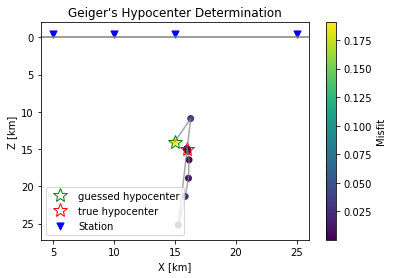

In [120]:
import matplotlib.pyplot as plt

# hiposenter tebakan
initial=[15,14,17]
plt.plot(initial[0], initial[1],'g*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='guessed hypocenter')

# hiposenter sebenarnya
plt.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')

# hiposenter setiap iterasi diwarnai berdasarkan ,misfit
im=plt.scatter(xs,zs,c=misfits)
plt.plot(xs,zs,color="grey",alpha=0.7)

#plot stasiun
plt.scatter(station_x,station_z-.5,marker="v",\
            color="blue",s=50, label="Station")
# permukaan (z=0)
plt.axhline(0, color="grey")

plt.xlabel("X [km]")
plt.ylabel("Z [km]")
plt.ylim(max(zs)+2,-2)
plt.title("Geiger's Hypocenter Determination")
plt.colorbar(im,label="Misfit")
plt.legend(loc="lower left")

dari plot di atas dapat kita lihat bahwa titik bergeser dan lama-lama mendekati hiposenter sebenarnya, untuk memperjelas kita akan coba *zoom*:

(14.0, 18.0)

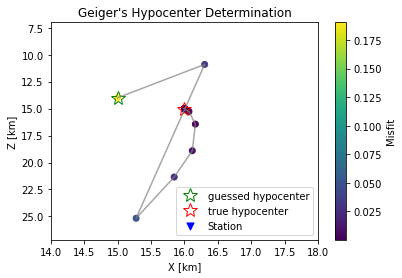

In [103]:
# hiposenter tebakan
initial=[15,14,17]
plt.plot(initial[0], initial[1],'g*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='guessed hypocenter')

plt.plot(source_x, source_z,'r*', markersize=15,markerfacecolor='None',\
        markeredgewidth=1,label='true hypocenter')
# hiposenter setiap iterasi diwarnai berdasarkan misfit
im=plt.scatter(xs,zs,c=misfits)
plt.plot(xs,zs,color="grey",alpha=0.7)

plt.xlabel("X [km]")
plt.ylabel("Z [km]")
plt.scatter(station_x,station_z-.5,marker="v",\
            color="blue",s=50, label="Station")
plt.axhline(0, color="grey")
plt.ylim(max(zs)+2,-2)
plt.title("Geiger's Hypocenter Determination")
plt.colorbar(im,label="Misfit")
plt.legend(loc="lower right")
plt.ylim(max(zs)+2,7)
plt.xlim(14,18)

## Latihan

Kita akan coba naik level ke 3 dimensi:

Stasiun-stasiun di bawah ini merekam gempa Vukano Tektonik di Merapi dengan waktu tiba gelombang P dijabarkan pada tabel di bawah, waktu 0s adalah 17.00.00 WIB.
Jika kecepatan homogen 3 km/s, cari hiposenter dan origin time!

| id	| nama	| alt| 	x	[m]| y [m]| arr [s]
|---|---|---|---|---| --- |
|1	|Gemer	|1331|	435634|	9166075| 1.2689472 |
|2	|Klatakan	|1880	|437186|	9167475| 1.11920458 |
|3|	Selo|	1883|	439270|	9168756| 1.23894408 |
|4|	Pasar Bubar|	2569|	439845|	9166732| 1.26084491 |
|5|	Kendil|	1622|	439937|	9164018 | 1.2827079|

![geigermerapi](figures/merapi_stations.png)

## Solusi

In [165]:
import math

# true hiposenter dan origin time
xt, yt, zt, T0t =  438613, 9166504, -1000, 0
print("Sebenarnya: ", xt, yt, zt, T0t)

# mendefinisikan kecepatan
v = 3000 #m/s

# menebak hiposenter
x, y, z, T0 = 437000, 9167000, -1500, 0.5
guess=[x,y,z,T0]
print("Tebakan: ", x, y, z, T0)


# mendefinisikan data [arr] dan koordinat stasiun
zss = np.array([1331, 1880, 1883, 2569, 1622])
xss = np.array([435634, 437186, 439270, 439845, 439937])
yss = np.array([9166075, 9167475, 9168756, 9166732, 9164018])
arrs = np.array([1.2689472, 1.11920458, 1.23894408, 1.26084491, 1.2827079])	
station_coor=[xss,yss,zss]

# membuat fungsi untuk menghitung jarak (phytagoras)
def distance(xs,ys,zs,x,y,z):
    x2 = (xs-x)**2
    y2 = (ys-y)**2
    z2 = (zs-z)**2
    d2 = x2 + y2 +z2
    d = np.sqrt(d2)
    return d

# membuat fungsi pemodelan maju
def t_arr_calc(xs,ys,zs,x,y,z,t0):
    t_arr = t0 + (distance(xs,ys,zs,x,y,z)/v)
    return t_arr

#misfit awal
d_calc = t_arr_calc(xss, yss, zss ,guess[0], guess[1], guess[2], guess[3])
d_calc = np.array(d_calc)
delta_d = d - d_calc
first_misfit = delta_d.T @ delta_d
#nantinya akan diisi kumpulan hasil inversi    
xsr,ysr,zsr,t0sr,misfitsr=[guess[0]],[guess[1]],[guess[2]],[guess[3]],[first_misfit]

# Melakukan perulangan
iterasi = 10
for it in range(iterasi):
  # looping untuk menghitung G per baris/stasiun
    G=np.ones([len(xss),len(guess)]) #membuat calon matriks G
    for j in range(len(xss)): #loop terhadap jumlah stasiun
        for i in range(len(guess)): #loop terhadap jumlah model
            if i==len(guess)-1: #diisi 1 jika kolom terakhir
                G[j,i]*=1
            else: #dihitung jika bukan kolom terakhir
                jarak=distance(station_coor[0][j],station_coor[1][j],station_coor[2][j],\
                                   guess[0],guess[1],guess[2]) #menghitung jarak D
                
                g_ji=(guess[i]-station_coor[i][j])/(jarak*v) #menghitung elemen setiap kolom dan baris
                G[j,i] *= g_ji

    # pemodelan maju
    d_calc = t_arr_calc(xss, yss, zss, x, y, z, T0)
    d_calc = np.array(d_calc)

    # definisikan GTGinv dan GTdeltad
    d = arrs
    GTG = G.T @ G
    GTGinv = np.linalg.inv(GTG)
    delta_d = d - d_calc
    GTdeltad = G.T @ delta_d

    # inversi untuk mencari delta m
    delta_m = GTGinv @ GTdeltad
  
    # mengoreksi model dengan delta_m
    x = x + delta_m[0]
    y = y + delta_m[1]
    z = z + delta_m[2]
    T0 = T0 + delta_m[3]
    guess = [x,y,z,T0]

    # menghitung misfit
    # forward model dg hasil baru
    d_calc = t_arr_calc(xss, yss, zss, x, y, z, T0)
    d_calc = np.array(d_calc)
    delta_d = d - d_calc
    misfit = delta_d.T @ delta_d

    # cetak hasil
    print(it+1, x, y, z, T0, misfit)
    
    #menyimpan hasil
    xsr.append(x)
    zsr.append(z)
    ysr.append(y)
    t0sr.append(T0)
    misfitsr.append(misfit)

Sebenarnya:  438613 9166504 -1000 0
Tebakan:  437000 9167000 -1500 0.5
1 438879.5176664631 9166347.100204917 -1195.9364341294859 0.0712695446322158 0.10005242466605085
2 438600.05921189854 9166507.384868357 -994.2698713609134 0.0055496288727372445 8.944350381738235e-05
3 438612.9791182956 9166503.997448578 -999.997827699973 7.508810636658314e-06 2.575219992512767e-10
4 438613.00000877236 9166504.000014976 -1000.0000457615135 -1.2770747593432961e-08 3.785277566896313e-18
5 438613.00000879937 9166504.000014981 -1000.0000457301554 -1.2779134514718713e-08 3.783894648824342e-18
6 438613.00000879937 9166504.000014981 -1000.0000457301588 -1.2779135539906801e-08 3.783894466432601e-18
7 438613.00000879937 9166504.000014981 -1000.0000457301591 -1.2779135552145621e-08 3.783894466432601e-18
8 438613.00000879937 9166504.000014981 -1000.0000457301593 -1.2779135564384442e-08 3.783894940504232e-18
9 438613.00000879937 9166504.000014981 -1000.0000457301575 -1.2779135118388336e-08 3.783894186369477e-18


### Bonus Plot dengan DEM

In [153]:
import xarray as xr
from affine import Affine 

da = xr.open_rasterio('data/map_utm_sm.tif')
transform = Affine.from_gdal(*da.attrs['transform']) # this is important to retain the geographic attributes from the file

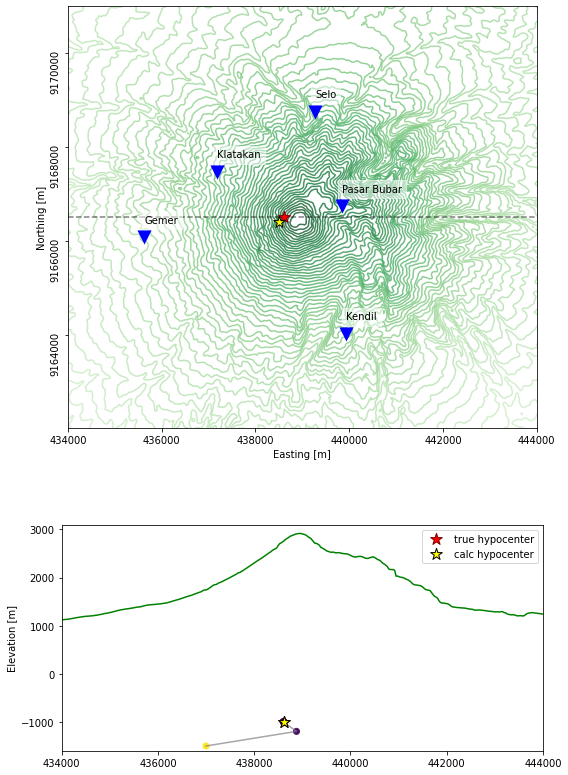

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# true hypocenter
xt, yt, zt = 438613, 9166504, -1000
 
# load seismic stations data
stations_data = pd.read_csv("data/merapi_stations.csv")
xs = [float(x) for x in stations_data['x']]
ys = [float(y) for y in stations_data['y']]
stas = list(stations_data['nama'])
 
# dem data
x = da.x.variable.data
y = da.y.variable.data
Z = da.variable.data[0]
 
fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(211)
X, Y = np.meshgrid(x, y) # create grid for contour (interpolation)
ax.contour(X,Y,Z, levels=80, cmap="Greens", alpha=.75) # contour
ax.scatter([xt],[yt], marker="*", color="red", edgecolor="maroon", s=150, zorder=12, label="true hypocenter") #truehyp
ax.scatter([xc],[yc], marker="*", color="yellow", edgecolor="black", s=150, zorder=12, label="calc hypocenter") # calchyp
ax.axhline(y=9166500, color="black", alpha=.5, linestyle="--") #slice line
 
ax.set_aspect(1)
ax.set_xlim(434000,444000)
ax.set_ylim(9162000,9171000)
ax.scatter(xs,ys, marker="v", s=200, color="blue", linewidth=0, zorder=10)
ax.tick_params(axis='y', labelrotation = 90)
ax.ticklabel_format(style="plain")
ax.set_yticks(np.arange(9164000,9172000, 2000))
ax.set_ylabel("Northing [m]")
ax.set_xlabel("Easting [m]")
 
for xsta, ysta, stat in zip(xs, ys, stas):
  ax.annotate(stat,[xsta,ysta+300], bbox=dict(color="white",alpha=0.5))
 
ax2 = fig.add_subplot(212)
res = []
for num in y:
  res.append(abs(num-9166500))
slice_index = np.where(res == min(res))[0]
slice_z = Z[slice_index,:]
ax2.plot(x, slice_z[0], color="green")
ax2.scatter([xt],[zt], marker="*", color="red", edgecolor="maroon", s=150, label="true hypocenter")
ax2.scatter(xsr[-1],zsr[-1], marker="*", color="yellow", edgecolor="black", s=150, zorder=12, label="calc hypocenter")
ax2.set_xlim(434000,444000)
ax2.set_ylim(-1600, 3100)
ax2.set_aspect(1)
ax2.set_ylabel("Elevation [m]")

# hiposenter setiap iterasi diwarnai berdasarkan misfit
im=plt.scatter(xsr,zsr,c=misfits)
plt.plot(xsr,zsr,color="grey",alpha=0.7)

plt.tight_layout()
plt.legend()
plt.savefig("merapi.png", dpi=144)